In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from arch.bootstrap import StationaryBootstrap
# from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
# from bootstrapped import bootstrap as bs
# from bootstrapped import compare_functions as cf
import hdbscan
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/s

In [7]:
from utils import create_abundance_header_new, compute_cons_abun_prod, hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, fit_dynamic_Ri, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data

# Get data

In [8]:
df_speciesMetab, df_speciesAbun, \
    df_speciesAbun_super_agar, \
    df_speciesAbun_mucin, \
    df_speciesAbun_inoc, \
    df_speciesAbun_ratio, \
    df_speciesAbun_super_agar_ratio, \
    df_speciesAbun_mucin_ratio, \
    df_speciesAbun_prev, \
    df_speciesAbun_super_agar_prev, \
    df_speciesAbun_mucin_prev, \
    df_speciesAbun_next, \
    df_speciesAbun_super_agar_next, \
    df_speciesAbun_mucin_next, metab_names, \
    species_names = \
        load_data()

In [9]:
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 3

# Parameter setup

In [10]:
date_ = '20230531'
distance_metric = 'euclidean'
# distance_metric = 'correlation'
metab_cluster_mean_func = 'geometric'
metab_cluster_mean_func = "linear"
clustering_method = "hdbscan"
clustering_method = "hierarch_clust"
random_seed = 635
# random_seed = 9876
# random_seed = 7360
# microcosm_type = "supernatantAgar"
# microcosm_type = "mucin"
microcosm_type = "noMicrocosm"

In [11]:
if microcosm_type == "noMicrocosm":
    df_speciesAbun_mdl = df_speciesAbun.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()
elif microcosm_type == "supernatantAgar":
    df_speciesAbun_mdl = df_speciesAbun_super_agar.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_super_agar_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_super_agar_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_super_agar_ratio.copy()
elif microcosm_type == "mucin":
    df_speciesAbun_mdl = df_speciesAbun_mucin.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_mucin_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_mucin_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_mucin_ratio.copy()

# cluster metabolites

In [12]:
# num_metabs_clust = df_speciesMetab.shape[1]
# id_rm = np.array(metab_rm_list)[range(22)]
# id_ = list(set(range(num_metabs_clust)) - set(list(id_rm)))
n_clusters = 4
df_metabs_clusters, df_speciesMetab_new = \
    get_metabs_clusters(df_speciesMetab.iloc[:, :].copy(), bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=n_clusters, distance_metric="euclidean", \
                        method_cluster="ward")

In [13]:
df_speciesMetab_cluster = avg_consumption_df(df_speciesMetab_new, df_metabs_clusters, \
                                             metab_cluster_mean_func="linear")

In [14]:
df_speciesMetab_cluster.shape

(63, 92)

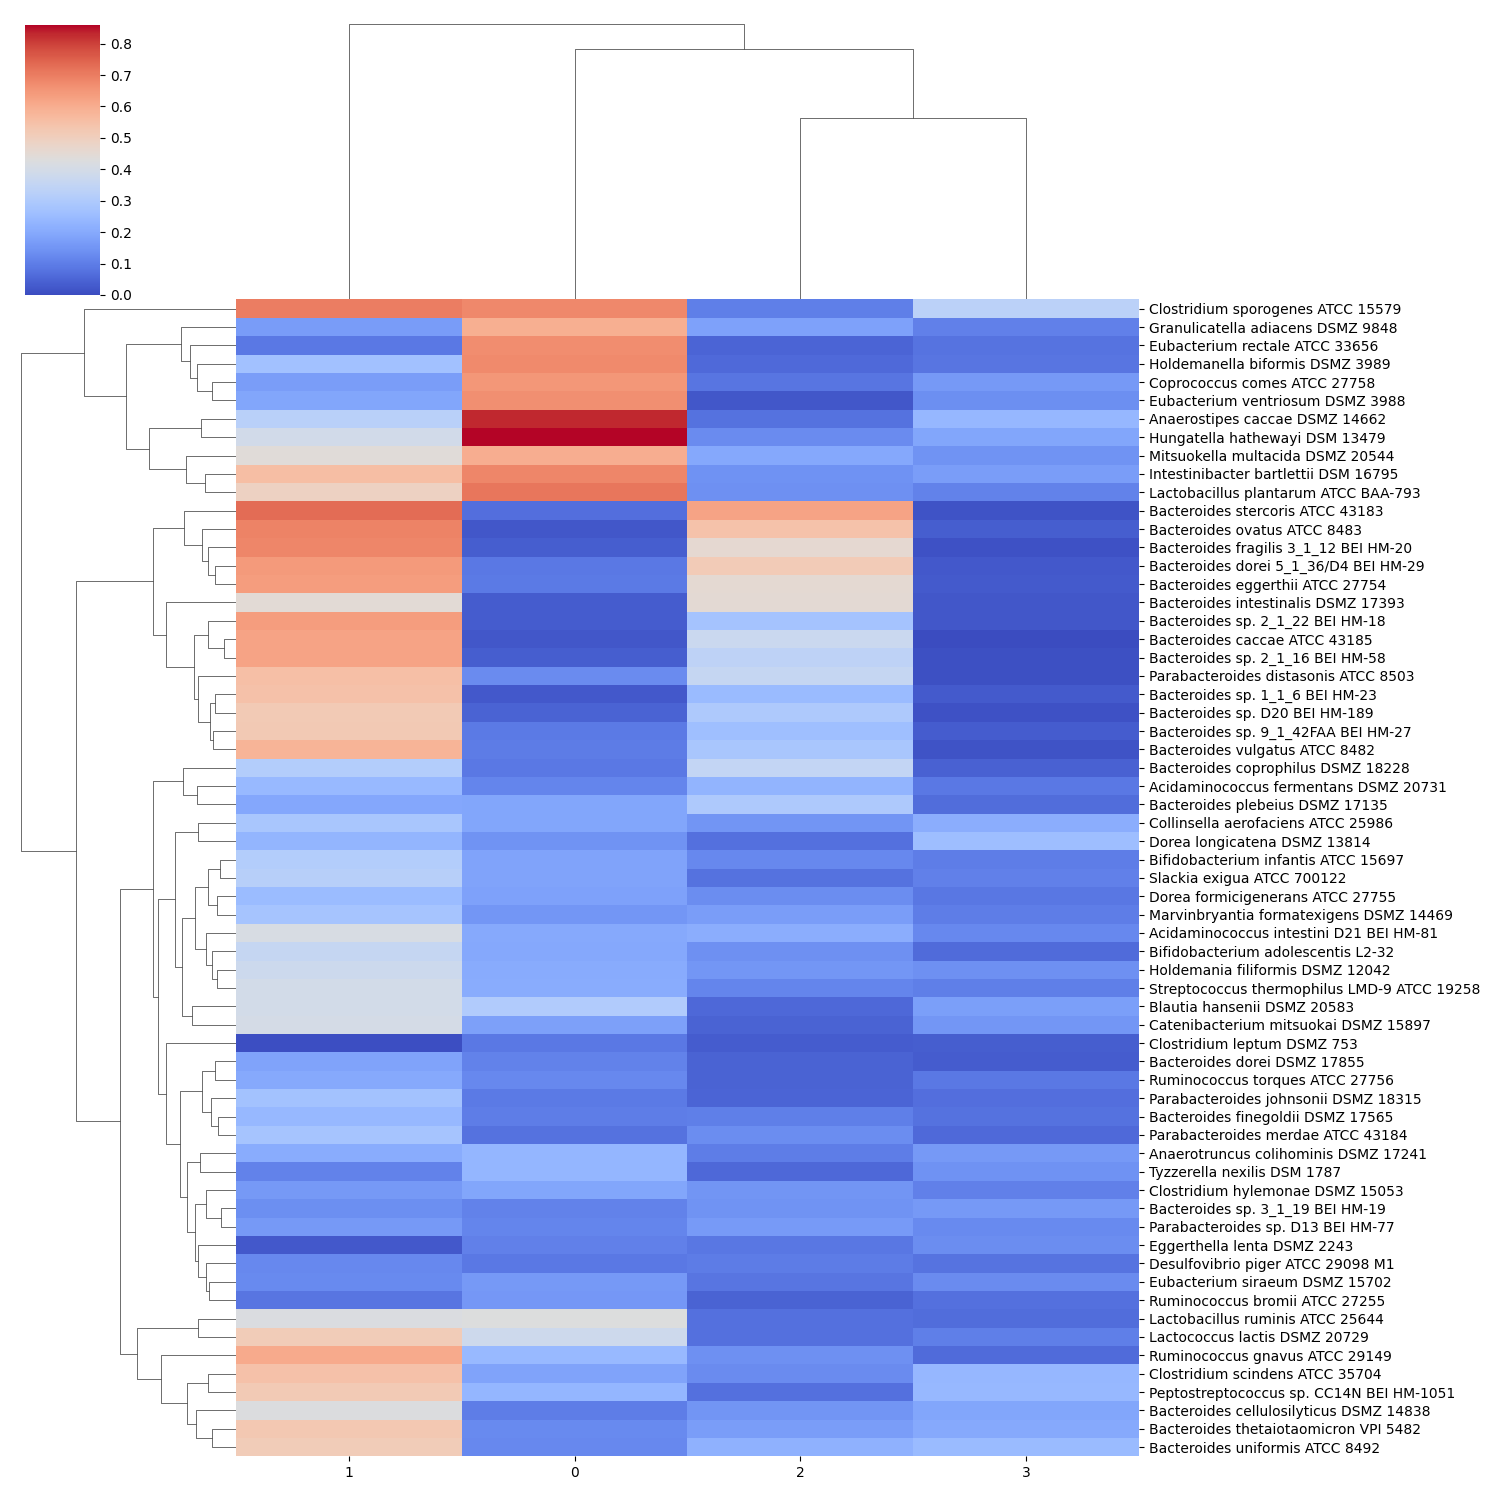

In [15]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(4)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [16]:
df_metabs_clusters.iloc[range(4), :]

cluster_labels  cluster_counts   
0               0              20  \
1               1              23   
2               2              54   
3               3              39   

                                   cluster_metab_IDs   
0  [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
1  [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2  [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
3  [1, 2, 6, 7, 9, 11, 17, 21, 24, 29, 32, 48, 49...   

                                  cluser_metab_names  
0  [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  
1  [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  
2  [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  
3  [NICOTINIC ACID, OLEIC ACID, 1-METHYL-HYDANTOI...

# RMSE as a function of number of clusters

In [17]:
def fit_Ri_tmp(df_speciesMetab_cluster, df_speciesAbun_prev_mdl, \
               df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6):
    ## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
    date_ = '20230530'
    n_repeats = 10
    rand_seed = 7363
    np.random.seed(rand_seed)
    p_vec_new = [0.1]


    num_metabs_clust = df_speciesMetab_cluster.shape[1]
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    Ri_dynamic_obj = {}
    # Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
    #                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                 df_speciesAbun_ratio_mdl, p_vec_new, \
    #                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
    pass_keep = np.arange(num_passages - 1)
    id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
    pass_rm = [2, 3, 4]
    Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                    df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                    file_save="dummy", num_passages=5, pass_rm=pass_rm, num_brep=3, \
                                    save_data=False)
    # Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
    #                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                       df_speciesAbun_ratio_mdl, p_vec_new, \
    #                                       file_save, num_passages=5, pass_rm=[3, 4])
    # Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
    #                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                       df_speciesAbun_ratio_mdl, \
    #                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
    # Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
    #                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                        df_speciesAbun_ratio_mdl, \
    #                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

            
    Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
    Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
    Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
    return Ri_noMicrocosm_dynamicAll_fit_joint

In [102]:
def get_RMSE(df_speciesMetab_cluster, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
             df_speciesAbun_ratio_mdl, Ri_noMicrocosm_dynamicAll_fit_joint, \
             df_speciesAbun_mdl_true=None, num_passages=6):
    num_metabs_clust = df_speciesMetab_cluster.shape[1]
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    p_vec_new = [0.1]
    count_p = 0

    RMSE_mat_full = np.zeros((num_passages - 1, 2))
    Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
    Ri_fit = {0: Ri_avg}
    # RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
    sens_obj_all, RMSE_obj_all = \
        blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                              df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                              df_speciesAbun_prev_mdl, \
                                              df_speciesAbun_ratio_mdl, \
                                              Ri_fit, "dummy", "dummy", \
                                              "dummy", num_passages=6, num_iter=100, \
                                              thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                              save_data_obj=False, \
                                              return_sensitivity_ana=True, \
                                              df_speciesAbun_mdl_true=df_speciesAbun_mdl_true)
    for pass_ in range(num_passages - 1):
        RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
        RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]
    return RMSE_mat_full

In [22]:
num_clusters = np.arange(1, 11)
RMSE_clusters = np.zeros((len(num_clusters), 2, 2))
p_vec_new = [0.1]
count_p = 0
for count_, nclust_ in enumerate(num_clusters):
    print(f'nclust = {nclust_}')
    df_metabs_clusters, df_speciesMetab_new = \
    get_metabs_clusters(df_speciesMetab.iloc[:, :].copy(), bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=nclust_, distance_metric="euclidean", \
                        method_cluster="ward")
    df_speciesMetab_cluster = avg_consumption_df(df_speciesMetab_new, df_metabs_clusters, \
                                                 metab_cluster_mean_func="linear")
    Ri_noMicrocosm_dynamicAll_fit_joint= \
        fit_Ri_tmp(df_speciesMetab_cluster, df_speciesAbun_prev_mdl, \
                   df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6)
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_cluster, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_noMicrocosm_dynamicAll_fit_joint, num_passages=6)
    print(f'p = {p_vec_new[count_p]}')
    RMSE_clusters[count_, :, :] = RMSE_mat_full[range(2), :].copy()
    

nclust = 1
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 2
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 3
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 4
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 5
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 6
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 7
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 8
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 9
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 10
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1


Text(0, 0.5, 'RMSE relative to #non-singleton clusters=10')

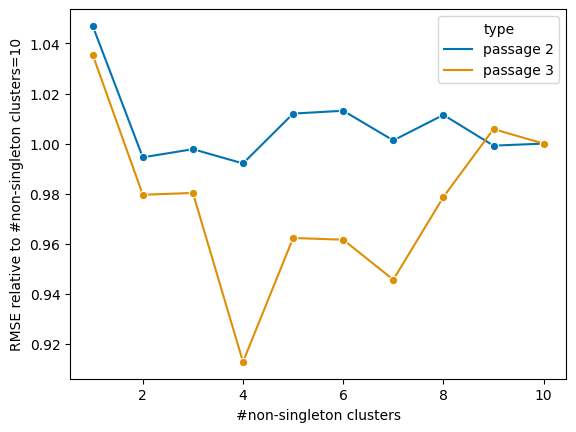

In [23]:
palette_ = sns.color_palette("colorblind", n_colors=2)
df_plt = pd.DataFrame(data={"x" : np.hstack([num_clusters, num_clusters]), \
                            "y" : (RMSE_clusters[:, :, 0] / RMSE_clusters[9, :, 0]).flatten(order='F'), \
                            "type" : ['passage 2'] * RMSE_clusters.shape[0] + \
                                ['passage 3'] * RMSE_clusters.shape[0]})
plt_ = sns.lineplot(data=df_plt, x="x", y="y", hue="type", palette=palette_, marker='o')
plt_.set_xlabel("#non-singleton clusters")
plt_.set_ylabel("RMSE relative to #non-singleton clusters=10")

## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs

In [28]:
df_metabs_clusters, df_speciesMetab_new = \
get_metabs_clusters(df_speciesMetab.iloc[:, :].copy(), bin_thresh=0.3, species_num_thresh=5, \
                    n_clusters_hclust=4, distance_metric="euclidean", \
                    method_cluster="ward")
df_speciesMetab_cluster = avg_consumption_df(df_speciesMetab_new, df_metabs_clusters, \
                                             metab_cluster_mean_func="linear")

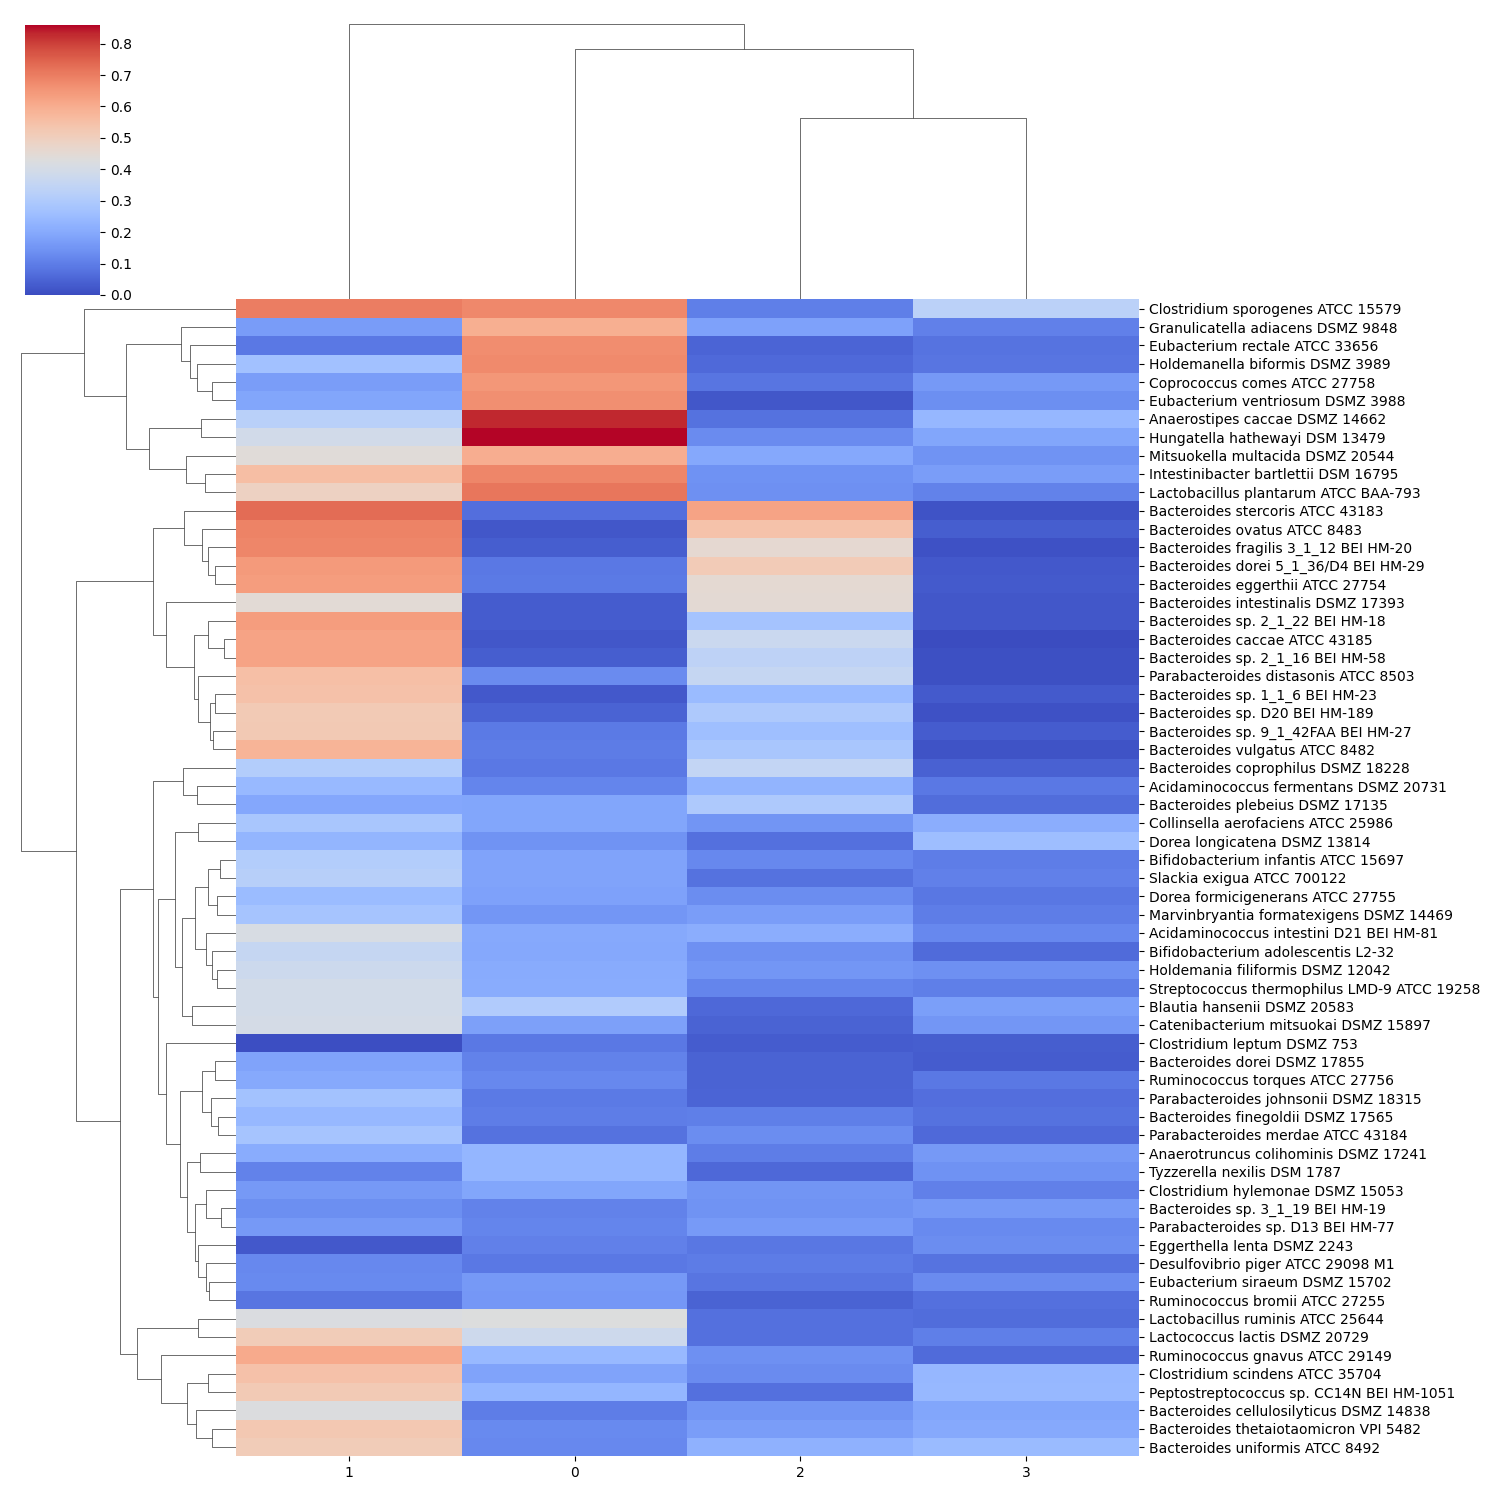

In [29]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(4)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [30]:
df_metabs_clusters.iloc[range(4), :]

cluster_labels  cluster_counts   
0               0              20  \
1               1              23   
2               2              54   
3               3              39   

                                   cluster_metab_IDs   
0  [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
1  [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2  [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
3  [1, 2, 6, 7, 9, 11, 17, 21, 24, 29, 32, 48, 49...   

                                  cluser_metab_names  
0  [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  
1  [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  
2  [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  
3  [NICOTINIC ACID, OLEIC ACID, 1-METHYL-HYDANTOI...

In [31]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230531'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2_2to3'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [2, 3, 4]
Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                file_save, num_passages=5, pass_rm=pass_rm, num_brep=3)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 1, p_tmp = 0.01


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 2, p_tmp = 0.05


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 3, p_tmp = 0.06


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 4, p_tmp = 0.07


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 5, p_tmp = 0.08


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 6, p_tmp = 0.09


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 7, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 8, p_tmp = 0.125


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 9, p_tmp = 0.15


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 10, p_tmp = 0.175


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 11, p_tmp = 0.2


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 12, p_tmp = 0.3


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 13, p_tmp = 0.4


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 14, p_tmp = 0.5


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Tar

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Tar

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Ta

count = 15, p_tmp = 0.55


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 16, p_tmp = 0.6


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 17, p_tmp = 0.65


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 18, p_tmp = 0.7


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

In [32]:
date_ = '20230531'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2_2to3'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [33]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                          df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                          df_speciesAbun_prev_mdl, \
                                          df_speciesAbun_ratio_mdl, \
                                          Ri_fit, "dummy", "dummy", \
                                          "dummy", num_passages=6, num_iter=100, \
                                          thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                          save_data_obj=False, \
                                          return_sensitivity_ana=True)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [34]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.iloc[:, :].copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
df_metabs_clusters_order.iloc[range(20), :]

cluster_labels  cluster_counts   
0                0              20  \
86              86               1   
1                1              23   
2                2              54   
74              74               1   
31              31               1   
39              39               1   
84              84               1   
18              18               1   
25              25               1   
3                3              39   
4                4               1   
17              17               1   
60              60               1   
58              58               1   
47              47               1   
76              76               1   
20              20               1   
64              64               1   
85              85               1   

                                    cluster_metab_IDs   
0   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
86                                              [218]   
1   [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2   [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
74                                              [206]   
31                                              [163]   
39                                              [171]   
84                                              [216]   
18                                              [150]   
25                                              [157]   
3   [1, 2, 6, 7, 9, 11, 17, 21, 24, 29, 32, 48, 49...   
4                                               [136]   
17                                              [149]   
60                                              [192]   
58                                              [190]   
47                                              [179]   
76                                              [208]   
20                                              [152]   
64                                              [196]   
85                                              [217]   

                                   cluser_metab_names        Ri  
0   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.163128  
86                                [PYROGLUTAMIC ACID]  0.148750  
1   [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  0.113981  
2   [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  0.057813  
74                               [N-ACETYLTRYPTOPHAN]  0.025076  
31                                     [BETA-LACTOSE]  0.024891  
39                                    [ACETYLCHOLINE]  0.024263  
84                                       [PYRIDOXINE]  0.024075  
18                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.023086  
25                                    [3-FUROIC ACID]  0.022004  
3   [NICOTINIC ACID, OLEIC ACID, 1-METHYL-HYDANTOI...  0.021367  
4                                     [GALACTOSAMINE]  0.016310  
17                        [IS_METHIONINE-METHYL-D3_0]  0.014926  
60                                         [CYTOSINE]  0.013678  
58                                       [CREATININE]  0.012152  
47                                           [3'-CMP]  0.011728  
76                                 [N-BUTYRYLGLYCINE]  0.009623  
20           [IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID_0]  0.009366  
64                                        [HISTAMINE]  0.008878  
85                                       [PYROGALLOL]  0.008036

In [36]:
df_metabs_clusters_order.iloc[range(20), 3].values

array([list(['BETA-ALANINE_0', 'OMEGA-HYDROXYDODECANOIC ACID', 'IS_PHENYLALANINE-2,3,4,5,6-D5_0', 'IS_D15-OCTANOIC ACID_0', 'IS_D19-DECANOIC ACID_0', 'IS_TRIDECANOIC ACID_0', 'IS_D27-TETRADECANOIC ACID_0', 'XANTHINE', '4-ACETAMIDOPHENOL', '3-HYDROXYPHENYLACETIC ACID', "5'-METHYLTHIOADENOSINE", 'ADENINE', 'CADAVERINE', 'CHOLINE', 'LUMICHROME', 'NICOTINAMIDE', 'PYRIDOXAMINE', "S-(5'-ADENOSYL)-L-HOMOCYSTEINE", 'SUBERIC ACID', 'URACIL']),
       list(['PYROGLUTAMIC ACID']),
       list(['MANNOSE 6-PHOSPHATE', 'THREONINE_0', 'CINNAMALDEHYDE', '1-METHYLADENOSINE', 'GLUCOSE', 'SUCROSE_1', '3-UREIDOPROPIONATE', 'GLYCERIC ACID', '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', '1,6-ANHYDRO-B-GLUCOSE', 'ADENOSINE', 'ASP-PHE', 'ASPARAGINE', 'CARNOSINE', 'GLUTAMINE', 'GLYCYL-GLYCINE', 'GUANOSINE', 'HYPOXANTHINE', 'INOSINE', 'METHYLMALONIC ACID_1', 'N-ACETYLNEURAMINATE', 'SERINE', 'URIDINE']),
       list(['N-METHYL-ASPARTIC ACID_0', 'CARNITINE', 'PHOSPHOCHOLINE', 'TRYPTOPHAN ETHYL ESTER', 'STEARIC ACID', 

## blind predict abundance

row = 0, col = 0


/tmp/ipykernel_7762/4156316726.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 0, col = 1
row = 0, col = 2
row = 1, col = 0


/tmp/ipykernel_7762/4156316726.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_7762/4156316726.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 1, col = 1


/tmp/ipykernel_7762/4156316726.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


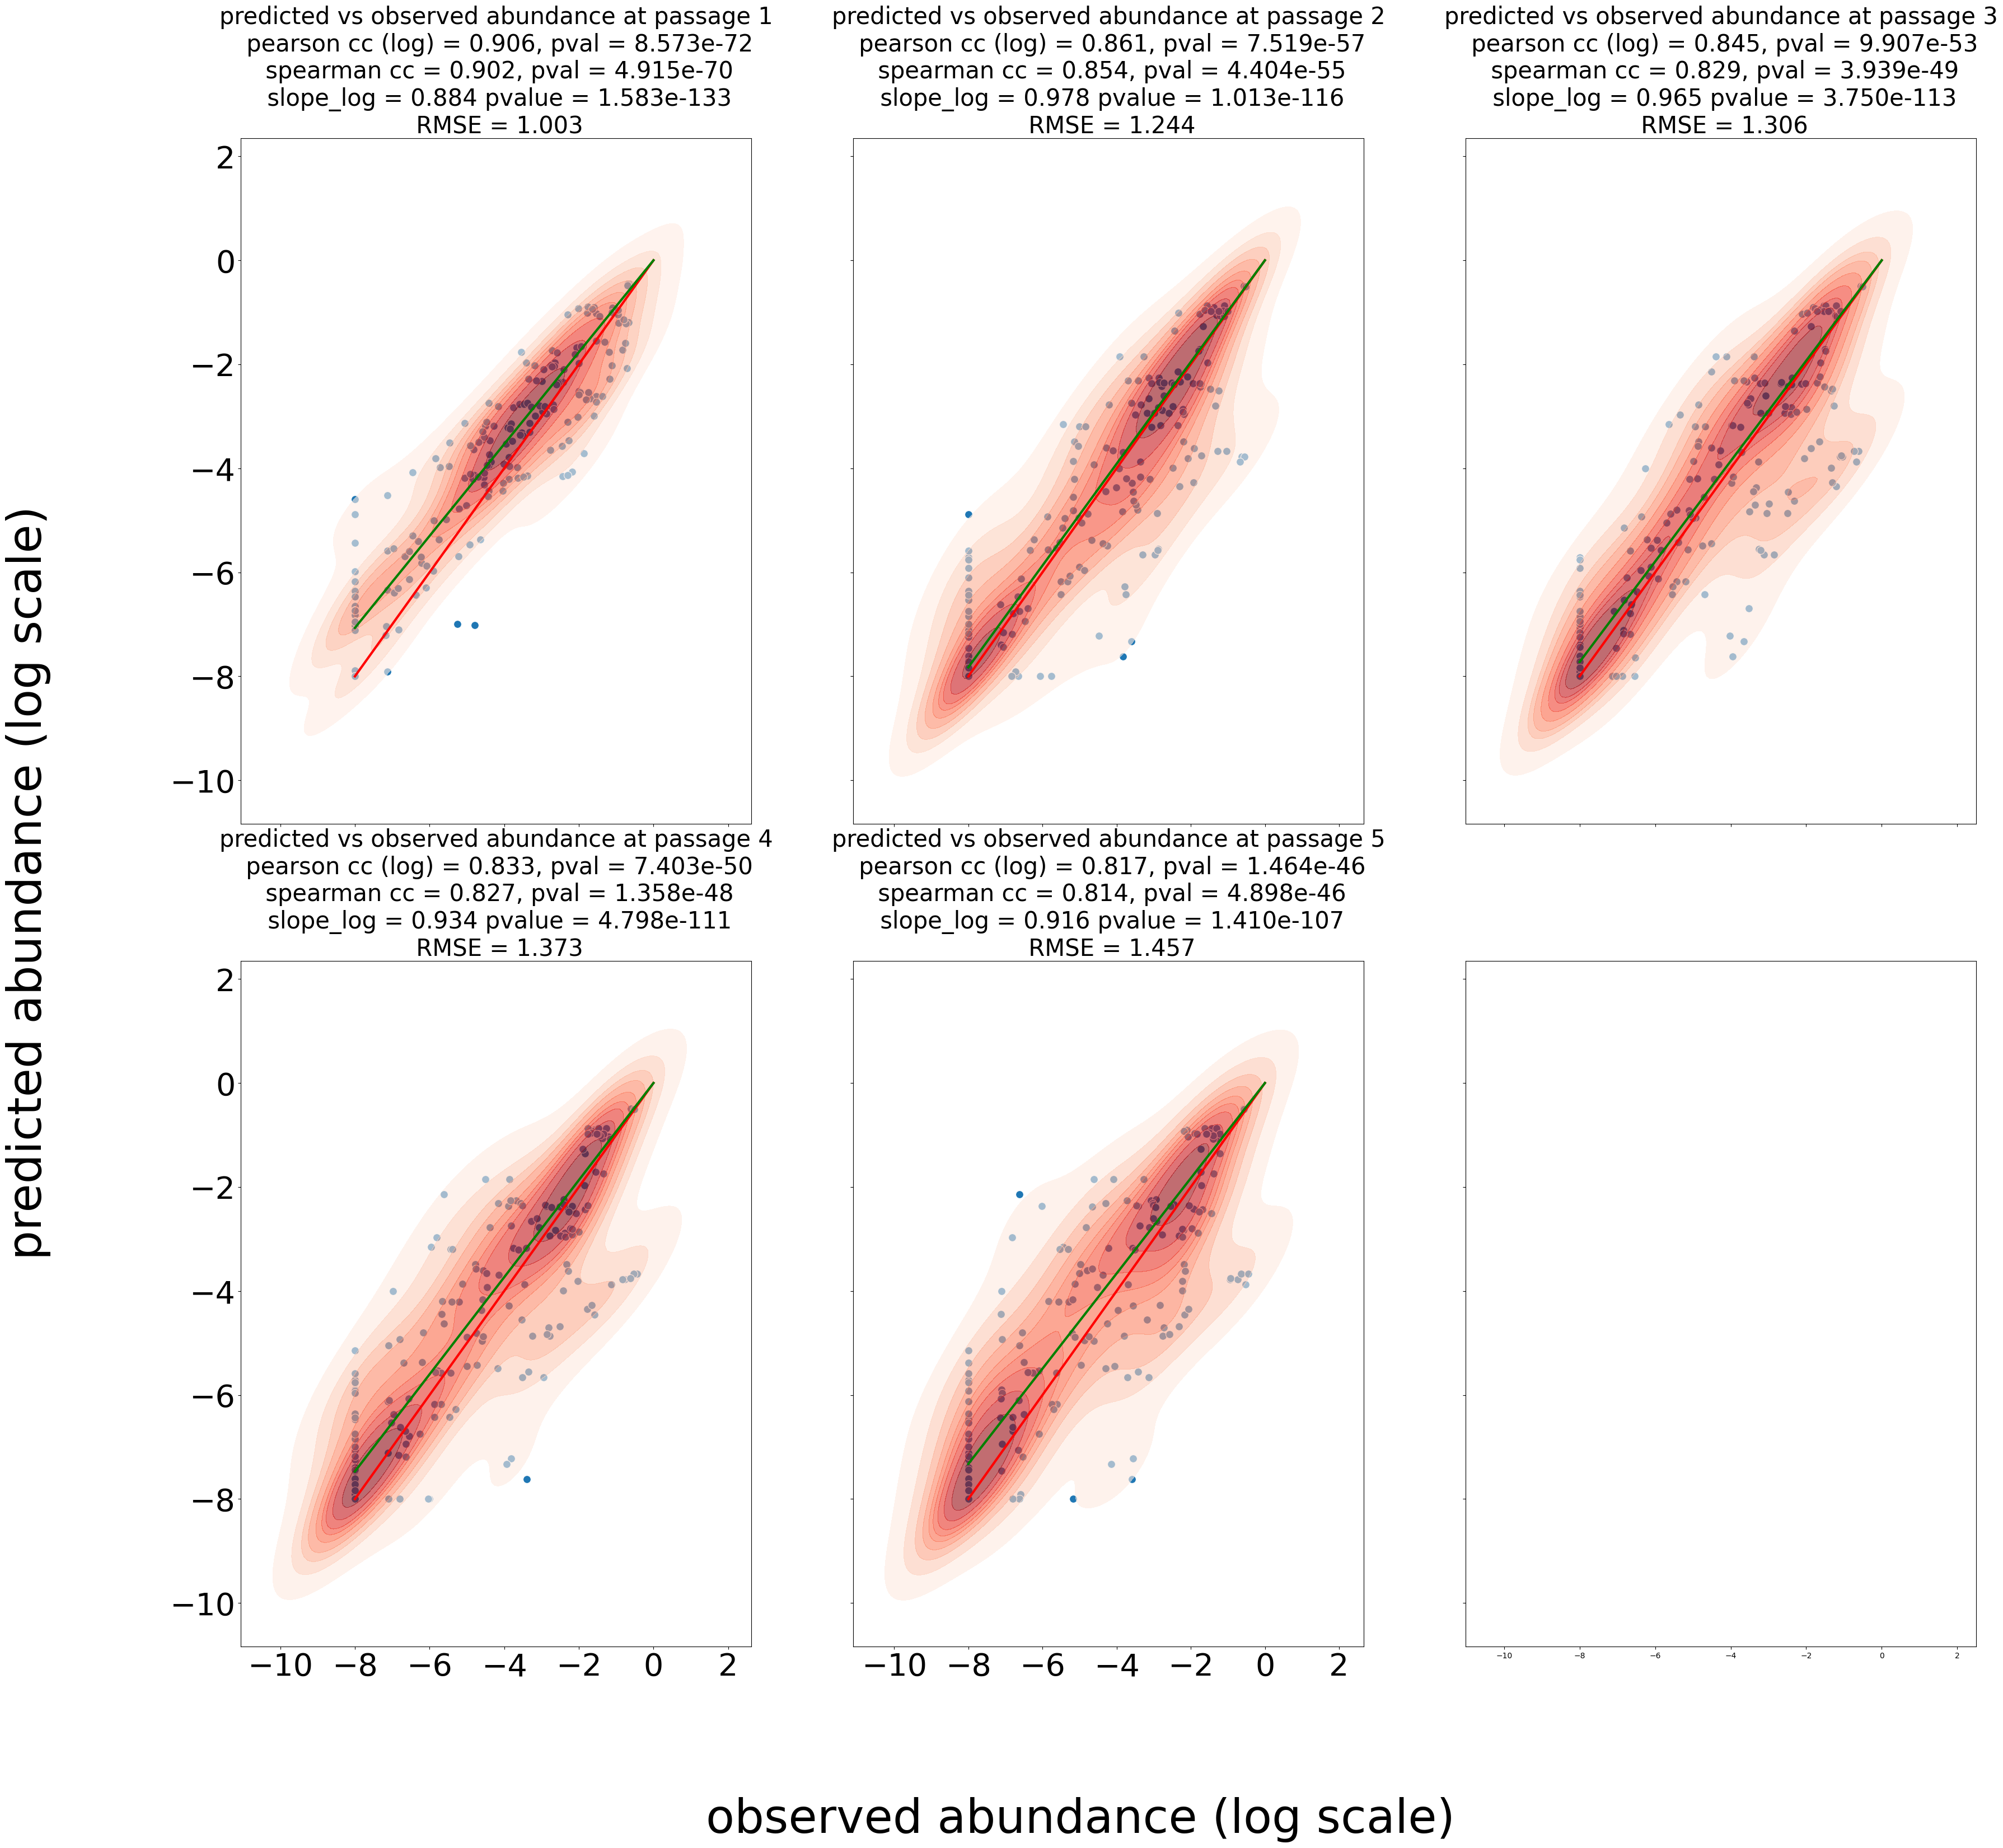

In [37]:
num_iter = 100
fig, axes = plt.subplots(2, int(num_passages / 2), \
                             figsize=(40, 35), sharey="row", sharex="col")
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(num_passages - 1):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')


    if pass_ <= 1:
        growth_rate_all = sens_obj_all[pass_]['growth_rate_all']
        df_speciesAbun_prev_tmp_ = sens_obj_all[pass_]['df_speciesAbun_prev']
        df_tmp = pd.DataFrame()
        for col_ in df_speciesAbun_prev_tmp_.columns.values:
            df_tmp[col_] = \
                growth_rate_all.copy()[col_].values * \
                df_speciesAbun_prev_tmp_[col_].values
            df_tmp[col_] /= np.sum(df_tmp[col_].values)
#         df_tmp = df_speciesAbun_next_mdl.iloc[:, [pass_, \
#                                                     pass_ + (num_passages - 1), \
#                                                     pass_ + 2 * (num_passages - 1)]].copy()

    b_ = range(3)
    x = \
        np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_ + 1, \
                                                    pass_ + 1 + num_passages, \
                                                    pass_ + 1 + 2 * num_passages]])
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = np.array(df_tmp.copy())[:, :].flatten()
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
    if ax_row_ == 1:
        plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)

# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                         'predictions', 'leaveOneOut', \
#                                         f'{date_}_for_paper_compare_greedy_rm_metabs' + \
#                                         f'_predict_abundance_blind_growth_ratio' + \
#                                         f'_Ri_fit_dynamic' + \
#                                         f'_nocluster_metabolites_new_hierachClust_{microcosm_type}' + \
#                                         f'_pass_1to2_2to3_notremove_metabs_greedy_pareto_clusteredMetabs'))
# if not os.path.exists(save_dir):
#    # Create a new directory because it does not exist
#    os.makedirs(save_dir)

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_abundance_' + \
#                                             f'consolidated' + \
#                                             f'_with_p{p_vec_new[count_p]}_dynamics_till_passage6_' + \
#                                             f'clusterMetabs.png'))

# fig.figure.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")
# plt.close(fig.figure)

## blind predict growth ratio

row = 0, col = 0


/tmp/ipykernel_7762/2460390363.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 0, col = 1
row = 0, col = 2
row = 1, col = 0


/tmp/ipykernel_7762/2460390363.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_7762/2460390363.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 1, col = 1


/tmp/ipykernel_7762/2460390363.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


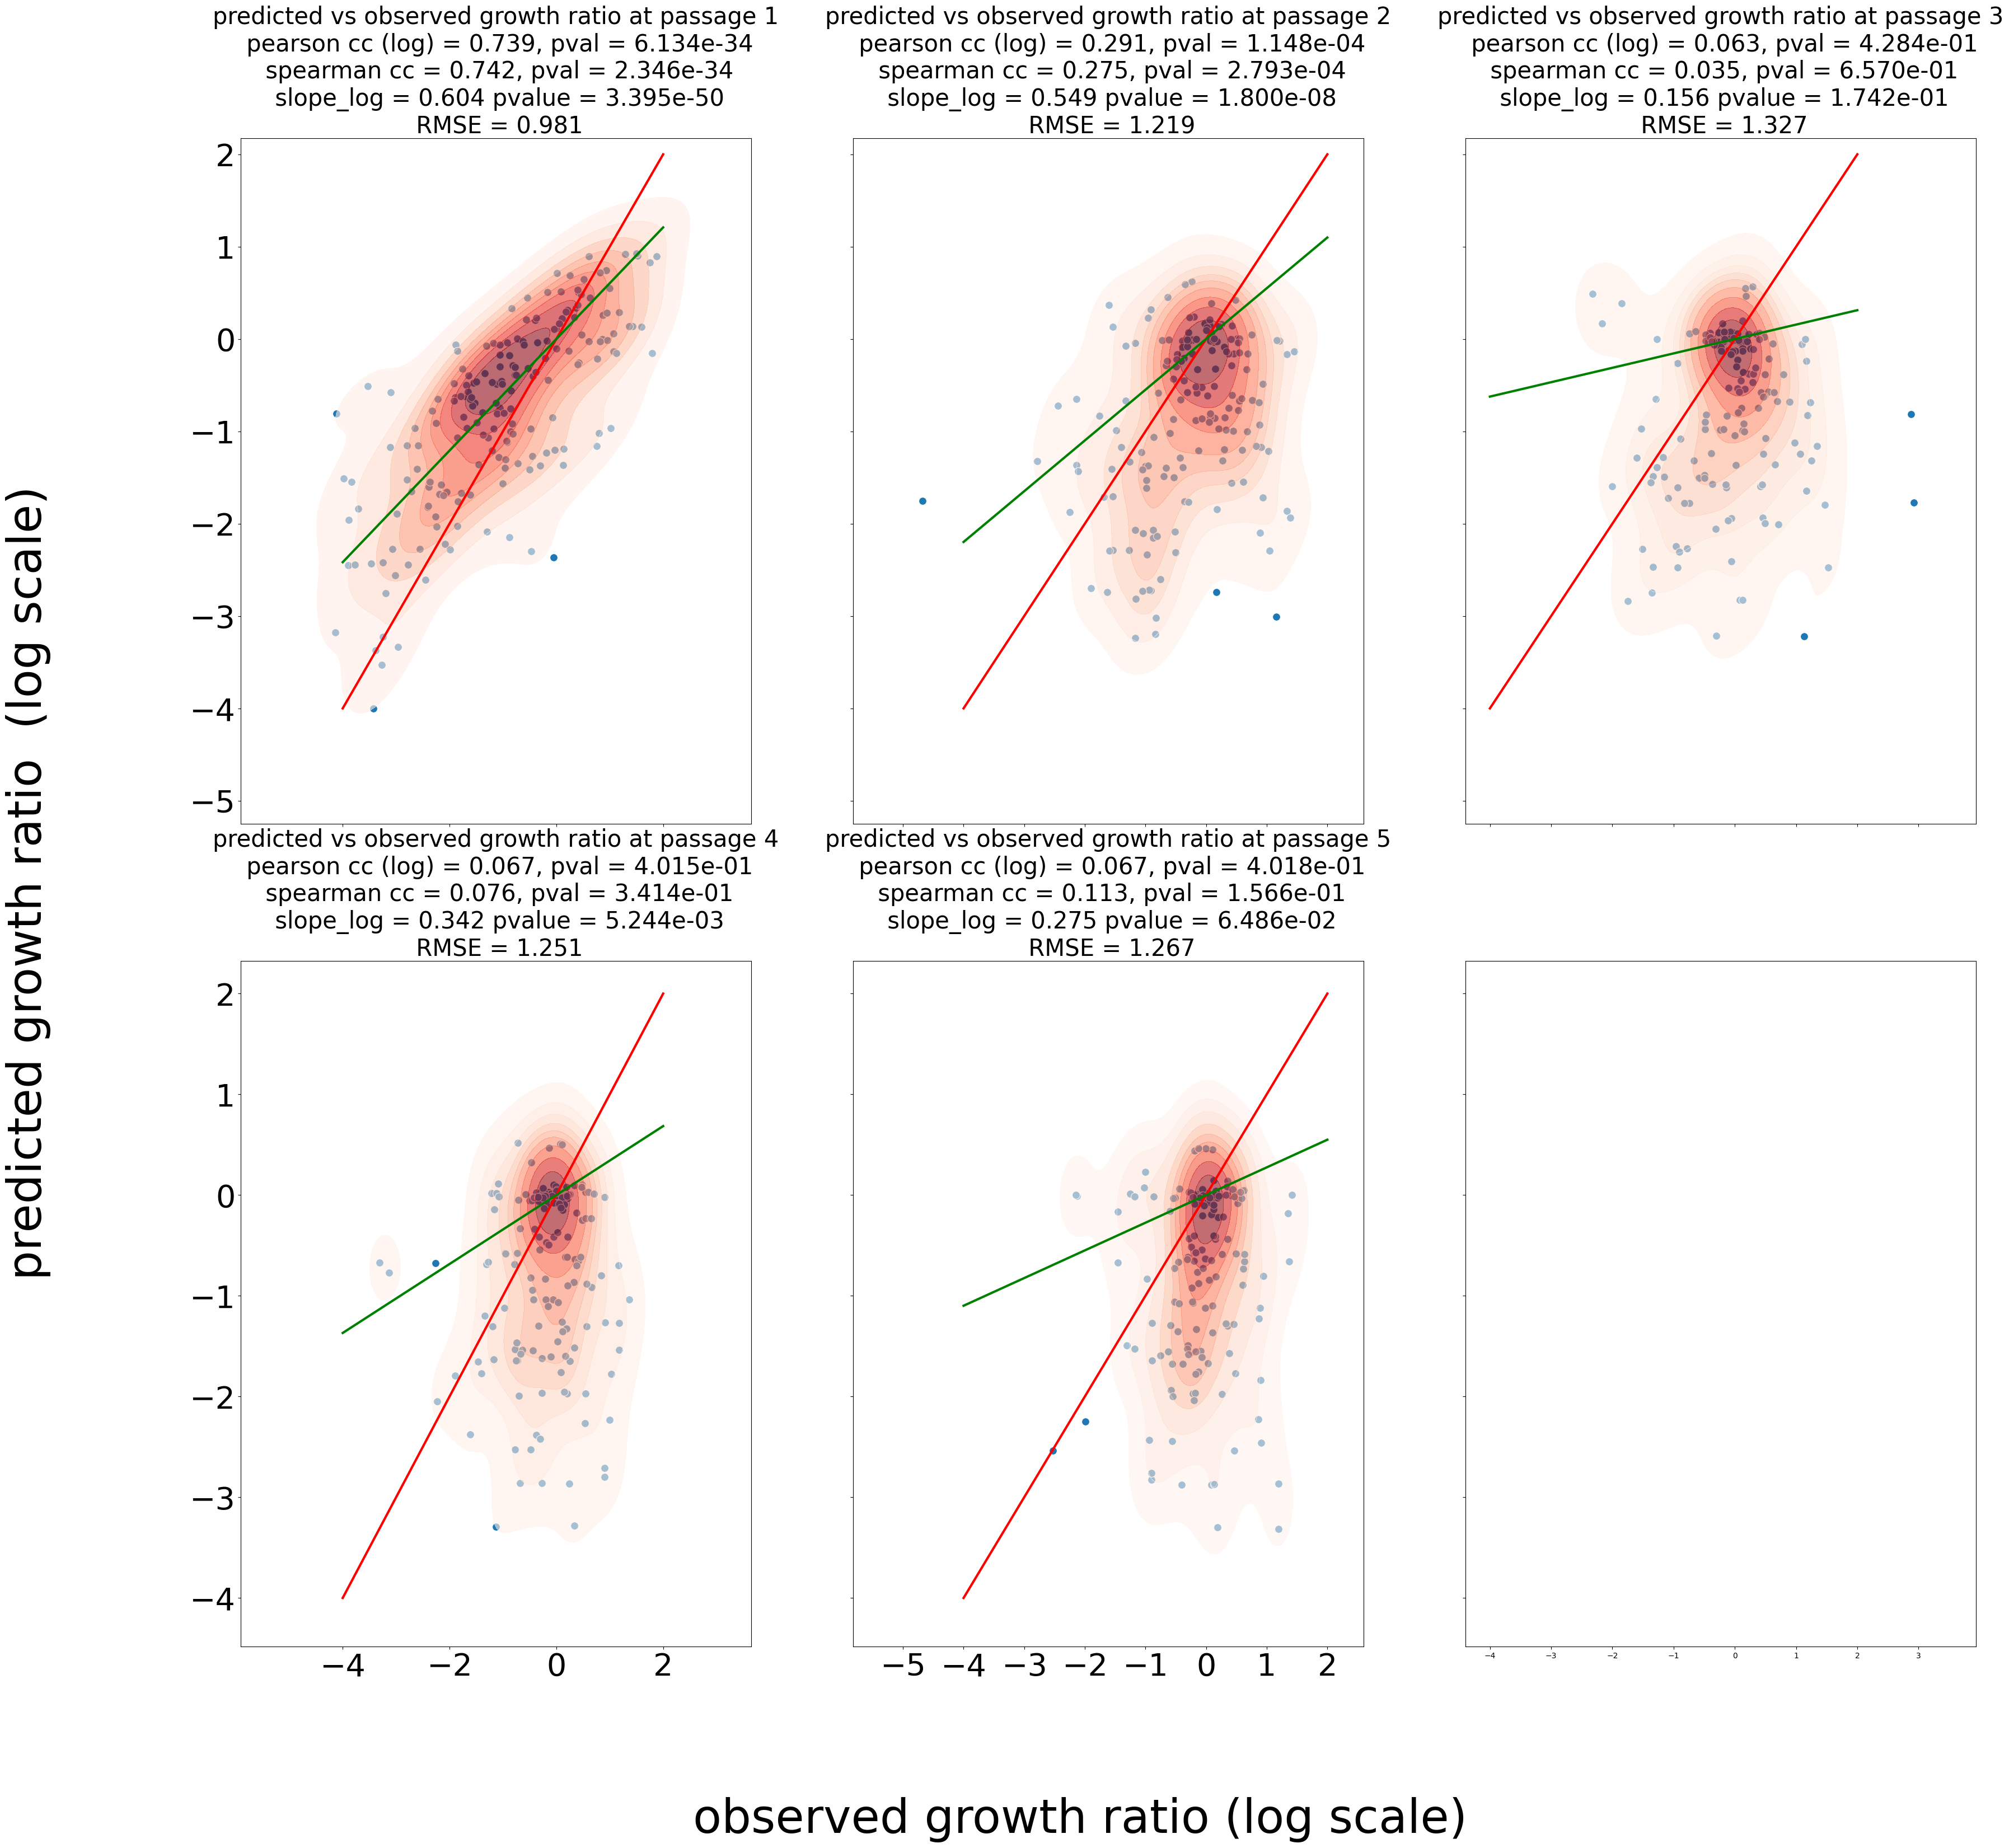

In [38]:
num_iter = 100
fig, axes = plt.subplots(2, int(num_passages / 2), \
                             figsize=(40, 35), sharey="row", sharex="col")
fig.supylabel('predicted growth ratio  (log scale)', fontsize=60)
fig.supxlabel('observed growth ratio (log scale)', fontsize=60)
for pass_ in range(num_passages - 1):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')


    if pass_ <= 10:
        growth_rate_all = sens_obj_all[pass_]['growth_rate_all']
        df_speciesAbun_prev_tmp_ = sens_obj_all[pass_]['df_speciesAbun_prev']
        df_tmp = pd.DataFrame()
        for col_ in df_speciesAbun_prev_tmp_.columns.values:
            df_tmp[col_] = \
                growth_rate_all.copy()[col_].values * \
                df_speciesAbun_prev_tmp_[col_].values
            df_tmp[col_] /= np.sum(df_tmp[col_].values)
#         df_tmp = df_speciesAbun_next_mdl.iloc[:, [pass_, \
#                                                     pass_ + (num_passages - 1), \
#                                                     pass_ + 2 * (num_passages - 1)]].copy()

    b_ = range(3)
#     x = \
#         np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_ + 1, \
#                                                     pass_ + 1 + num_passages, \
#                                                     pass_ + 1 + 2 * num_passages]])
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    
    x = \
        np.array(df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, \
                                                    pass_ + num_passages - 1, \
                                                    pass_ + 2 * (num_passages - 1)]])
    x = x.flatten()
#     y = np.array(df_tmp.copy())[:, :].flatten()
    y = np.array(growth_rate_all.copy()).flatten()
    thresh_zero = 1e-4
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -4] = -4

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-4, 2], [-4, 2], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -4) & (y <= -4))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed growth ratio at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
    if ax_row_ == 1:
        plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)

# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                         'predictions', 'leaveOneOut', \
#                                         f'{date_}_for_paper_compare_greedy_rm_metabs' + \
#                                         f'_predict_abundance_blind_growth_ratio' + \
#                                         f'_Ri_fit_dynamic' + \
#                                         f'_nocluster_metabolites_new_hierachClust_{microcosm_type}' + \
#                                         f'_pass_1to2_2to3_notremove_metabs_greedy_pareto_clusteredMetabs'))
# if not os.path.exists(save_dir):
#    # Create a new directory because it does not exist
#    os.makedirs(save_dir)

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_growth_' + \
#                                             f'consolidated' + \
#                                             f'_with_p{p_vec_new[count_p]}_dynamics_till_passage3_' + \
#                                             f'clusterMetabs.png'))

# fig.figure.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")
# plt.close(fig.figure)

# Find keystone metabolite clusters

In [61]:
count_p = 7
Ri_complete = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [40]:
num_metabs = df_speciesMetab_cluster.shape[1]
RMSE_metabs_clust_rm = np.zeros((num_metabs, 2, 2))

for m_ in range(num_metabs):
    print(f'loop = {m_}')
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    id_keep = list(set(list(range(num_metabs))) - set([m_]))
    df_speciesMetab_tmp = df_speciesMetab_tmp.iloc[:, id_keep]
    Ri_tmp = \
        fit_Ri_tmp(df_speciesMetab_tmp, df_speciesAbun_prev_mdl, \
                   df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6)
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_tmp, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_tmp, num_passages=6)
    RMSE_metabs_clust_rm[m_, :, :] = RMSE_mat_full[range(2), :].copy() 

loop = 0
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 1
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 2
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 3
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 4
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 5
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 6
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 7
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 8
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 9
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 10
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 11
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 12
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 13
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 14
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 15
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 16
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 17
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 18
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 19
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 20
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 21
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 22
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 23
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 24
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 25
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 26
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 27
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 28
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 29
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 30
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 31
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 32
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 33
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 34
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 35
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 36
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 37
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 38
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 39
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 40
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 41
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 42
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 43
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 44
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 45
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 46
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 47
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 48
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 49
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 50
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 51
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 52
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 53
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 54
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 55
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 56
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 57
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 58
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 59
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 60
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 61
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 62
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 63
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 64
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 65
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 66
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 67
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 68
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 69
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 70
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 71
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 72
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 73
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 74
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 75
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 76
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 77
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 78
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 79
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 80
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 81
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 82
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 83
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 84
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 85
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 86
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 87
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 88
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 89
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 90
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 91
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

In [44]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_comp = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                          df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                          df_speciesAbun_prev_mdl, \
                                          df_speciesAbun_ratio_mdl, \
                                          Ri_fit, "dummy", "dummy", \
                                          "dummy", num_passages=6, num_iter=100, \
                                          thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                          save_data_obj=False, \
                                          return_sensitivity_ana=True)
for pass_ in range(num_passages - 1):
    RMSE_mat_comp[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_comp[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [45]:
RMSE_mat_comp

array([[1.00308866, 0.98063032],
       [1.24386658, 1.21869474],
       [1.66754409, 1.32746838],
       [1.93984124, 1.25066903],
       [2.18161873, 1.26708284]])

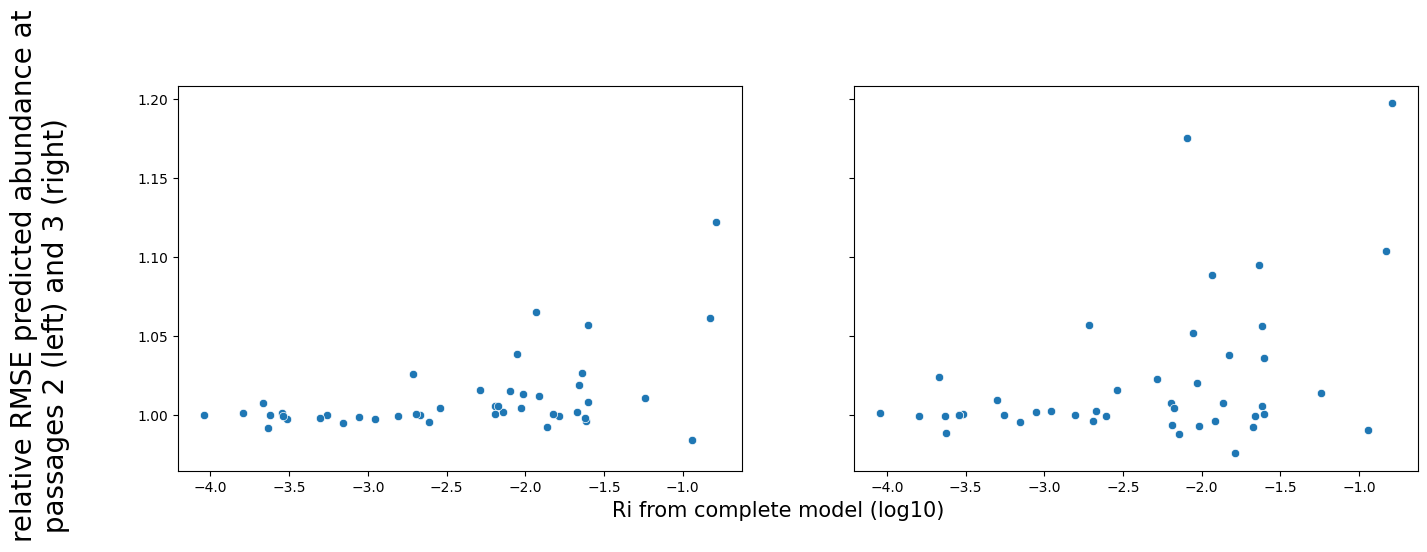

In [85]:
vals_ = RMSE_metabs_clust_rm[:, :, 0].copy() / RMSE_mat_comp[np.range(2), 0].copy()
x = vals_[:, 0]
y = vals_[:, 1]
z = Ri_complete.copy()
z[z == 0] = 1e-7
z = np.log10(z)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey="row", sharex="col")
fig.supylabel(f'relative RMSE predicted abundance at\n passages 2 (left) and 3 (right)', fontsize=20)
fig.supxlabel('Ri from complete model (log10)', fontsize=15)
id_ = np.where((z <= -7))[0]
id_keep = list(set(list(range(num_metabs))) - set(list(id_)))
plt_ = sns.scatterplot(x=z[id_keep], y=x[id_keep], ax=axes[0])
plt_ = sns.scatterplot(x=z[id_keep], y=y[id_keep], ax=axes[1])

In [101]:
id_y = np.where(y >= 1.075)[0]
print(Ri_complete[id_y])
# print(Ri_complete[id_y])
df_metabs_clusters.iloc[id_y[[1, 2, 3]], :]

[0.16312813 0.0230857  0.01172822 0.00803561 0.14874984]


cluster_labels  cluster_counts cluster_metab_IDs   
18              18               1             [150]  \
47              47               1             [179]   
85              85               1             [217]   

                   cluser_metab_names  
18  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  
47                           [3'-CMP]  
85                       [PYROGALLOL]

In [99]:
id_x = np.where(x >= 1.05)[0]
print(Ri_complete[id_x[[1, 2]]])
df_metabs_clusters.iloc[id_x[[1, 2]], :]

[0.01172822 0.0250763 ]


cluster_labels  cluster_counts cluster_metab_IDs    cluser_metab_names
47              47               1             [179]              [3'-CMP]
74              74               1             [206]  [N-ACETYLTRYPTOPHAN]

## keystone species

In [109]:
num_metabs = df_speciesMetab_cluster.shape[1]
RMSE_species_rm = np.zeros((num_species, 2, 2))
Ri_tmp = Ri_complete.copy()
Ri_fit = {0 : Ri_tmp}

for m_ in range(num_species):
    print(f'loop = {m_}')
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    df_speciesAbun_mdl_tmp = df_speciesAbun_mdl.copy()
    df_speciesAbun_mdl_tmp.iloc[m_, :] = 0
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_tmp, df_speciesAbun_mdl_tmp, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_fit, num_passages=6, \
                 df_speciesAbun_mdl_true=df_speciesAbun_mdl.copy())
    RMSE_species_rm[m_, :, :] = RMSE_mat_full[range(2), :].copy() 

loop = 0
loop = 1
loop = 2
loop = 3
loop = 4
loop = 5
loop = 6
loop = 7
loop = 8
loop = 9
loop = 10
loop = 11
loop = 12
loop = 13
loop = 14
loop = 15
loop = 16
loop = 17
loop = 18
loop = 19
loop = 20
loop = 21
loop = 22
loop = 23
loop = 24
loop = 25
loop = 26
loop = 27
loop = 28
loop = 29
loop = 30
loop = 31
loop = 32
loop = 33
loop = 34
loop = 35


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: divide by zero encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: invalid value encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = 

loop = 36
loop = 37
loop = 38
loop = 39
loop = 40
loop = 41
loop = 42
loop = 43
loop = 44
loop = 45
loop = 46
loop = 47
loop = 48
loop = 49
loop = 50
loop = 51


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: divide by zero encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: invalid value encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = 

loop = 52
loop = 53
loop = 54
loop = 55
loop = 56
loop = 57
loop = 58
loop = 59
loop = 60
loop = 61
loop = 62


ValueError: All arrays must be of the same length

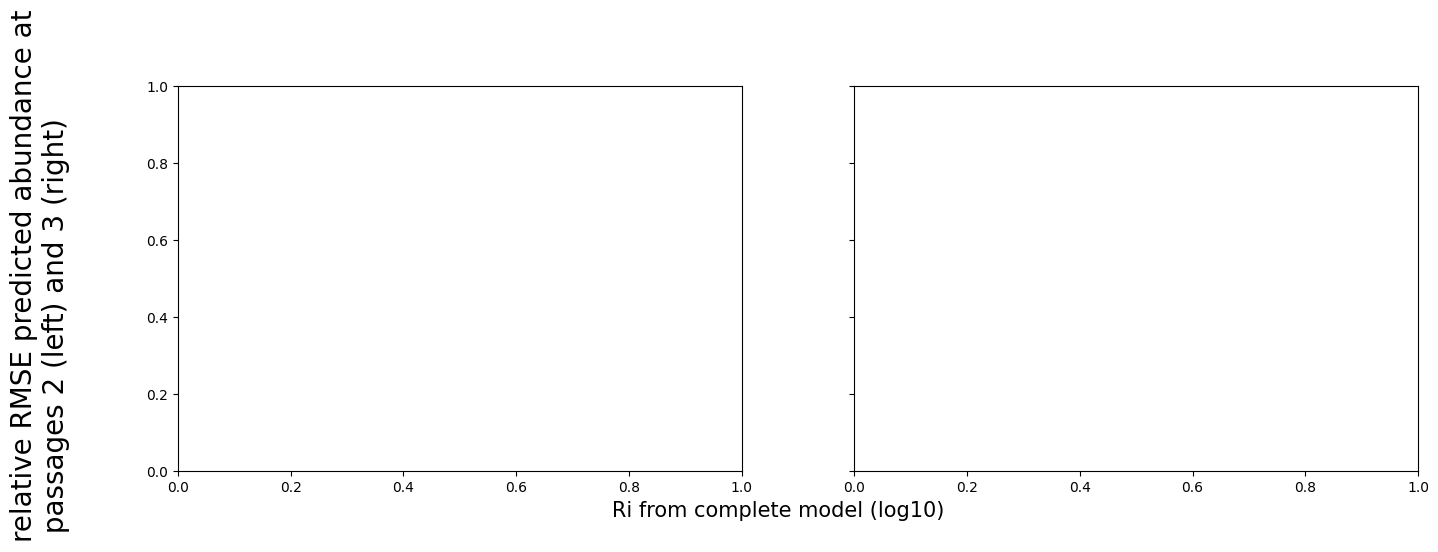

In [113]:
vals_ = RMSE_species_rm[:, :, 0].copy() / RMSE_mat_comp[range(2), 0].copy()
x = vals_[:, 0]
y = vals_[:, 1]
pass_ = [2, 2 + 6, 2 + 12]
z = np.array(df_speciesAbun_mdl.iloc[:, pass_])
z = np.mean(np.log10(z), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey="row", sharex="col")
fig.supylabel(f'relative RMSE predicted abundance at\n passages 2 (left) and 3 (right)', fontsize=20)
fig.supxlabel('Ri from complete model (log10)', fontsize=15)
plt_ = sns.scatterplot(x=z, y=x, ax=axes[0])
plt_ = sns.scatterplot(x=z, y=y, ax=axes[1])

In [115]:
RMSE_mat_comp

array([[1.00308866, 0.98063032],
       [1.24386658, 1.21869474],
       [1.66754409, 1.32746838],
       [1.93984124, 1.25066903],
       [2.18161873, 1.26708284]])